https://towardsdatascience.com/multi-label-classification-and-class-activation-map-on-fashion-mnist-1454f09f5925

In [1]:
import os 
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [2]:
train_dir = 'mnist_png/mnist_png/training/'
test_dir = 'mnist_png/mnist_png/testing/'

In [3]:
batch_size = 32
num_classes = 10
epochs = 1

learning_rate = 0.01
input_shape = (28, 28, 1)

In [4]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='same')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3))(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.25)(net)

net = layers.Conv2D(64, (3, 3), padding='same')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3))(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
# net = layers.Dropout(0.25)(net)

net = layers.GlobalAveragePooling2D()(net)
net = layers.Dense(num_classes, activation='softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net)


model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
#     save_to_dir='out_images'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [6]:
model.fit_generator(train_generator,
                    steps_per_epoch=2000,
                    epochs=1
                   )

Instructions for updating:
Use tf.cast instead.
  25/1875 [..............................] - ETA: 15:14 - loss: 2.3114 - acc: 0.0838

KeyboardInterrupt: 

In [7]:
model.save('gap_model.h5')

# Prepare for Visualize CAM

In [8]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# import Keras's functional api
from tensorflow.keras.models import Model

from PIL import Image

path = 'mnist_png/mnist_png/training/0/1.png'
image = np.array(Image.open(path).convert('L'))
image = image.reshape((1, 28, 28, 1))

In [9]:
train_img_size_h = 28
train_img_size_w = 28

In [10]:
model.layers

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
__________

In [13]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(64, 10)

In [17]:
model.layers[-3]

In [15]:
cam_model = Model(inputs=model.input, outputs=(model.layers[-3].output, model.layers[-1].output)) 

In [19]:
features, results = cam_model.predict(image)
features.shape

(1, 5, 5, 64)

In [21]:
idx = 0

features_for_one_img = features[idx, :, :, :]
features_for_one_img.shape

(5, 5, 64)

NameError: name 'cam_features' is not defined

In [26]:
cam_features.shape

(28, 28, 64)

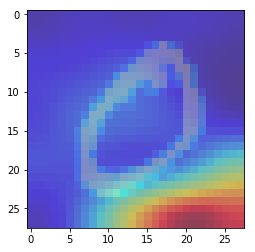

In [25]:
# get the weights from the last layer
gap_weights = model.layers[-1].get_weights()[0]

# create a new model to output the feature maps and the predicted labels
cam_model = Model(inputs=model.input, outputs=(model.layers[-3].output, model.layers[-1].output)) 

# make the prediction for a set of test images
features, results = cam_model.predict(image)

# check the prediction for 10 test images
for idx in range(1):   
    # get the feature map of the test image
    features_for_one_img = features[idx, :, :, :]

    # map the feature map to the original size
    height_roomout = train_img_size_h / features_for_one_img.shape[0]
    width_roomout = train_img_size_w / features_for_one_img.shape[1]
    cam_features = sp.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout, 1), order=2)
        
    # get the predicted label with the maximum probability
    pred = np.argmax(results[idx])
    
    # prepare the final display
    plt.figure(facecolor='white')
    
    # get the weights of class activation map
    cam_weights = gap_weights[:, pred]

    # create the class activation map
    cam_output = np.dot(cam_features, cam_weights)
    
    plt.imshow(image[idx, :, :, 0], alpha=0.5)
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
     
    plt.show()